模型优化策略
1. LeNet -> ResNet    
2. Data Augmentation
3. Add Epoches
4. Sample filtering  

前50%正确样本预训练 -> 用预训练模型筛选后50%样本 -> 正式学习

1. 过滤至45.98%样本，adam优化器，初始学习率0.001，REduceLROnPlateau，无梯度裁剪，num_epoch=155，最终表现61.36%
过滤阈值0.584，比例47.88%，SGD优化器，初始学习率0.01，REduceLROnPlateau，无梯度裁剪，前12epoch学习速度比上面快一倍，accuracy=40.2%
2. 过滤至13.64%样本，SGD优化器，初始学习率0.01，余弦退火策略，梯度裁剪上限1.0，在1的模型数据训练基础上继续训练，num_epoch=61，最终表现65.17%
3. 过滤至7.18%样本，SGD优化器，初始学习率0.012，余弦退火策略，梯度裁剪上限1.0，在2的模型数据训练基础上继续训练，num_epoch=64，最终表现65.2%
其中较明显的错误是把dog类标注成cat类，后续优化的突破口之一
4. 在3的基础上增大初始学习率为0.014，num_epoch=11，最终表现66.72%
5. 在5的基础上增大初始学习率为0.016，完全排除后50%训练集只使用确保正确的前50%，num_epoch=60，最终表现71.40%
6. 改变调整学习率策略为ReduceLROnPlateau，效果较明显，num_epoch=168，最终表现为76.71%
一些突破口：
a. epoch全部结束时学习率是多少，再次训练时的初始学习率是否应该调整为对应值
b. 优化器和调整学习率策略函数的参数调整
c. 模型对cat类错误十分明显，针对性解决
d. 模型在验证集(用训练集代替)上的性能超出在测试集上性能约6%，过拟合程度如何，如何改善

修改了数据归一化的均值和标准差，模型重新训练，推翻之前记录的最佳参数
1. 过滤阈值0.95，SGD优化，学习率预热+余弦退火+Plateau策略，数据使用训练集均值&标准差归一化，模型删除一个卷积块，在最后一个fc层之前添加了一个dropout层，num_epoch=39,最终表现15.4%

由于修改后模型最终输出不应该添加softmax层导致训练严重失误，改回原模型之后重新训练
1. 过滤阈值0.99，SGD优化，Plateau策略，num_epoch=228,最终表现76.97%
2. 在1的基础上：优化器添加nesterov动量，plateau策略patience减小为4，num_epoch=73,表现77.85%

dense layer改为3全连接层加2dropout
1. 人工监控，手动调整学习率，根据准确率修改权重，表现79.33%

In [3]:
#Data Loading
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Subset,ConcatDataset
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np

torch.manual_seed(42)

#mean=[0.4914, 0.4822, 0.4465]
#std=[0.2470, 0.2435, 0.2616]

mean=[0.5, 0.5, 0.5]
std=mean

# 定义数据转换，包括使用计算的均值和标准差进行归一化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# 加载训练集和测试集，并应用相同的转换
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 加载修改后的标签
modified_labels = np.load('./modified_labels.npy')
train_dataset.targets = modified_labels.tolist()

# 创建DataLoader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

c:\Users\lenovo\anaconda3\envs\py38\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Files already downloaded and verified
Files already downloaded and verified
Using device: cpu


In [4]:
#Sample Filtering
from baseline import Net,CIFAR10Model
net = Net()
net.load_state_dict(torch.load("tutorial.pth"))

# 创建新的数据子集，包含训练数据集的后 50%
train_dataset_length = len(train_dataset)
start_idx = train_dataset_length // 2
end_idx = train_dataset_length
subset_indices = list(range(start_idx, end_idx))
rough_dataset = Subset(train_dataset, subset_indices)
roughdata_loader = DataLoader(rough_dataset, batch_size=64, shuffle=False)

# Compute confidence scores for each training sample
net.eval()
all_confidences = []

with torch.no_grad():
    for data in roughdata_loader:
        images, labels = data
        outputs = net(images)
        probabilities = torch.softmax(outputs, dim=1)
        confidences, predictions = torch.max(probabilities, dim=1)
        all_confidences.extend(confidences.cpu().numpy())

all_confidences = np.array(all_confidences)

# 根据阈值过滤数据
confidence_threshold = 0.99
filtered_indices = np.where(all_confidences >= confidence_threshold)[0]
filtered_dataset = torch.utils.data.Subset(rough_dataset, filtered_indices)
print(f"Length of filtered dataset: {len(filtered_dataset)}")

# 合并数据集得到最终训练集
train_subset = Subset(train_dataset, list(range(0, len(train_dataset) // 2)))
final_trainset = ConcatDataset([train_subset, filtered_dataset])
print(f"Length of final train set: {len(final_trainset)}")

# threshold  filtered_dataset_length
# 0.95       1795
# 0.9        3410
# 0.8        6181
# 0.7        8804
# 0.6        11495

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Length of filtered dataset: 328
Length of final train set: 25328


Files already downloaded and verified


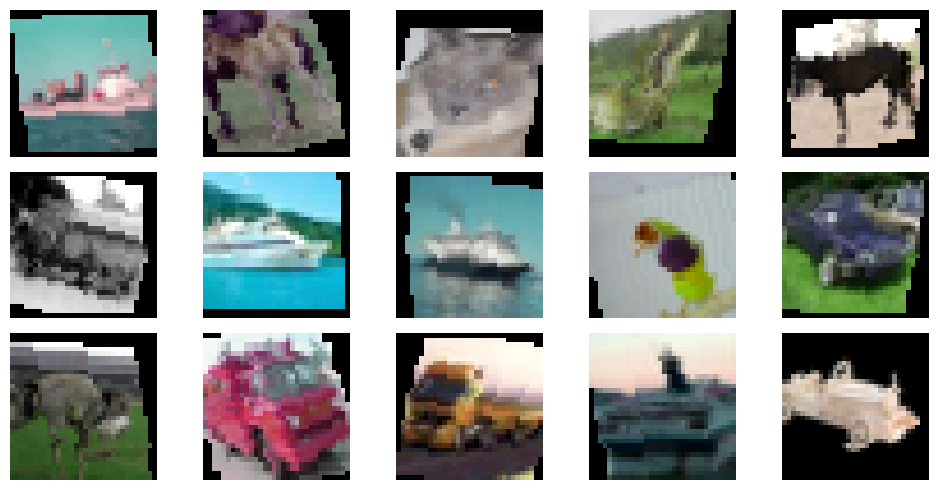

In [5]:
#Data Augmentation
import matplotlib.pyplot as plt

# 数据增强的操作
transform1 = transforms.Compose([
    transforms.RandomRotation(15),              # 随机旋转角度 ±15°
    transforms.RandomHorizontalFlip(),          # 随机水平翻转

    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),     # 随机调整亮度
    transforms.RandomAffine(degrees=0,          # 随机仿射变换
                            translate=(0.1, 0.1), 
                            scale=(0.9, 1.1), 
                            shear=10),
#    transforms.RandomResizedCrop(32),           # 随机裁剪和缩放
#    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=0.5),  # 随机透视变换
#    图片尺寸太小，不适合使用随机裁剪&随机透视
#    transforms.RandomApply([transforms.RandomErasing(p=1, scale=(0.02, 0.2))], p=0.5),
#    随机擦除涉及到图片的'shape'属性，不能用于处理这里的图片数据(Numpy)          
    transforms.ToTensor(),                      # 转为张量
    transforms.Normalize(mean, std)  # 标准化
])

# 使用 transform 对数据集进行增强
test_augmented_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform1)

# 显示数据增强后的图像
def show_images(test_dataset, num_images=5, h=1, w=5):
    
    fig, axs = plt.subplots(h, w, figsize=(10, 5))
    if h == 1:
        axs = np.expand_dims(axs, axis=0)
    for i in range(h):
        for j in range(w):
            idx = torch.randint(len(test_dataset), size=(1,)).item()
            image, _ = test_dataset[idx]
            
            npimg = np.array(image) / 2 + 0.5  # unnormalize
            npimg = np.transpose(npimg, (1, 2, 0))
            axs[i, j].imshow(npimg)
            axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

show_images(test_augmented_dataset, num_images=15, h=3, w=5)

In [7]:
#Training the Model
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import ToPILImage
to_pil = ToPILImage()

class EarlyStopping:
    def __init__(self, patience=7, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, train_loss):
        score = train_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(train_loss)
        elif score > self.best_score - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(train_loss)
            self.counter = 0

    def save_checkpoint(self, train_loss):
        # 保存最优模型
        torch.save(model.state_dict(), 'checkpoint.pth')
        self.train_loss_min = train_loss

early_stopping = EarlyStopping(patience=8, delta=0.001)

"""
warmup_epochs = 10
def warmup_lambda(epoch):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    return 1
"""

# 根据训练各类别预测的准确率重新分配权重
weights = torch.tensor([1.00,0.87,1.09,1.07,0.97,1.22,0.98,1.03,0.88,0.89], dtype=torch.float32)

model = CIFAR10Model().to(device)
model.load_state_dict(torch.load("finalmodel.pth"))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=5e-4, nesterov=True)
#restart1训练1轮后最终学习率为0.00125，将2轮后的学习率设置为0.001
#restart2训练1轮后最终学习率为0.00001，将2轮后的学习率设置为1e-5
#optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)  # 使用 AdamW 优化器
plateau_scheduler = ReduceLROnPlateau(optimizer, 'min', patience=4, factor=0.1,min_lr=1e-6)
#warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)
#cosine_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=23, T_mult=2, eta_min=1e-7)

num_epochs = 300
train_loss = []
train_accuracy = []
lr_list = []
lr_curr=1e-4

for epoch in range(num_epochs):
    # 重新生成训练集的数据加载器
    train_loader = DataLoader(final_trainset, batch_size=64, shuffle=True, 
                              collate_fn=lambda batch: (torch.stack([transform1(to_pil(item[0])) for item in batch]),
                                                    torch.tensor([item[1] for item in batch])))
    model.train()
    lr_list.append(optimizer.param_groups[0]['lr'])
    with tqdm(train_loader, unit='batch') as tepoch:
        epoch_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tepoch:
            images, labels = to_device(images, device), to_device(labels, device)
            tepoch.set_description(f'Epoch {epoch+1}/{num_epochs}')
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            epoch_loss += loss.item()
            
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            tepoch.set_postfix(loss=loss.item(), accuracy=correct / total)

        epoch_loss /= len(train_loader)
        train_loss.append(epoch_loss)
        train_accuracy.append(correct / total)
        print(f"Training Loss: {epoch_loss:.4f}")
        if lr_curr!=optimizer.param_groups[0]['lr']:
            lr_curr=optimizer.param_groups[0]['lr']
            print(f"Learning Rate at epoch{epoch}: {lr_curr:.6f}")
    
    # 调整学习率        
    plateau_scheduler.step(epoch_loss)

    # 检查是否需要早停
    early_stopping(epoch_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# 打印最终学习率
print(f"Final Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

# 可视化训练过程
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', color='blue')
plt.title('Loss Evolution')  

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy', color='red')
plt.title('Accuracy Evolution')  
plt.show()  

Epoch 1/300: 100%|██████████| 396/396 [01:24<00:00,  4.70batch/s, accuracy=0.808, loss=0.413]


Training Loss: 0.5747


Epoch 2/300: 100%|██████████| 396/396 [01:23<00:00,  4.75batch/s, accuracy=0.808, loss=0.554]


Training Loss: 0.5753


Epoch 3/300: 100%|██████████| 396/396 [01:23<00:00,  4.72batch/s, accuracy=0.812, loss=0.395]


Training Loss: 0.5694


Epoch 4/300: 100%|██████████| 396/396 [01:23<00:00,  4.74batch/s, accuracy=0.808, loss=0.678]


Training Loss: 0.5735


Epoch 5/300: 100%|██████████| 396/396 [01:23<00:00,  4.73batch/s, accuracy=0.808, loss=0.443]


Training Loss: 0.5748


Epoch 6/300: 100%|██████████| 396/396 [01:23<00:00,  4.73batch/s, accuracy=0.809, loss=0.497]


Training Loss: 0.5741


Epoch 7/300: 100%|██████████| 396/396 [01:24<00:00,  4.71batch/s, accuracy=0.811, loss=0.542]


Training Loss: 0.5690


Epoch 8/300: 100%|██████████| 396/396 [01:24<00:00,  4.71batch/s, accuracy=0.811, loss=0.621]


Training Loss: 0.5687


Epoch 9/300: 100%|██████████| 396/396 [01:25<00:00,  4.62batch/s, accuracy=0.812, loss=0.687]


Training Loss: 0.5680


Epoch 10/300: 100%|██████████| 396/396 [01:24<00:00,  4.67batch/s, accuracy=0.812, loss=0.475]


Training Loss: 0.5739


Epoch 11/300:  33%|███▎      | 131/396 [00:27<00:56,  4.71batch/s, accuracy=0.824, loss=0.408]


KeyboardInterrupt: 

Accuracy for class: plane is 79.7 %
Accuracy for class: car   is 89.5 %
Accuracy for class: bird  is 70.8 %
Accuracy for class: cat   is 78.5 %
Accuracy for class: deer  is 81.1 %
Accuracy for class: dog   is 55.9 %
Accuracy for class: frog  is 80.3 %
Accuracy for class: horse is 79.5 %
Accuracy for class: ship  is 88.0 %
Accuracy for class: truck is 89.5 %
Accuracy of the network on the 10000 test images: 79.28%


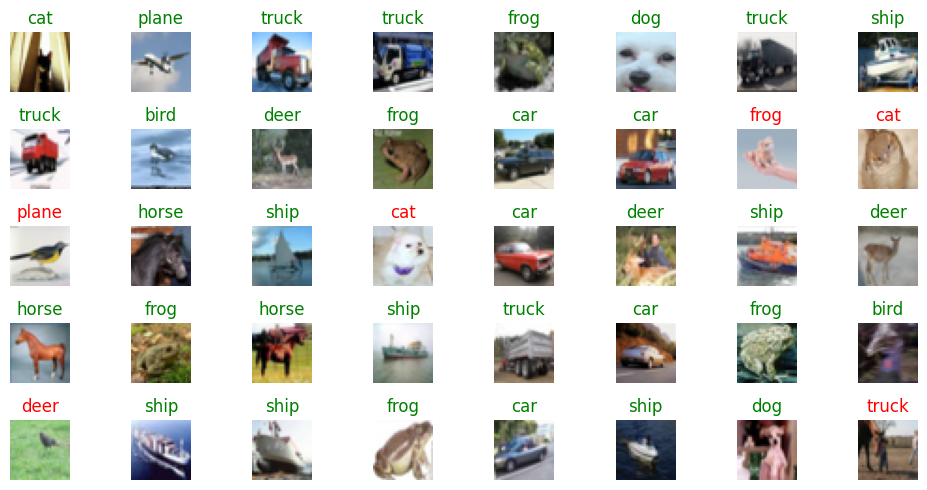

In [8]:
#Evaluation

# CIFAR-10类别标签
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

model.load_state_dict(torch.load("checkpoint.pth"))
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = to_device(images, device), to_device(labels, device)           
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# 打印每个类别的准确率
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    accuracy = test_correct / test_total

print(f'Accuracy of the network on the 10000 test images: {100*accuracy:.2f}%')

# 选择要显示的图片数量
num_images = 40
# 创建图形和子图
fig, axs = plt.subplots(5, 8, figsize=(10, 5))
axs = axs.ravel()

for i in range(num_images):
    idx = torch.randint(len(test_dataset), size=(1,)).item()
    image, label = test_dataset[idx]
    # 使用训练好的模型进行预测
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0)
        image = image.to(device)
        output = model(image)
        _, predicted = torch.max(output.data, 1)
        predicted_label = predicted.item()
    # 反归一化
    image = image / 2 + 0.5  # unnormalize
    npimg = image.cpu().numpy()[0]
    # 显示图片，并根据预测结果设置标签颜色
    axs[i].imshow(np.transpose(npimg, (1, 2, 0)))
    axs[i].set_title(classes[predicted_label], color='red' if label != predicted_label else 'green')
    axs[i].axis('off')
plt.tight_layout()
plt.show()